# **Stroke Detection from Brain CT Scans**


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')  # Ignore all warnings


In [3]:
# Load images from folders
normal_dir = '/content/drive/My Drive/coding_challenge/Normal/normal'
stroke_dir = '/content/drive/My Drive/coding_challenge/Stroke/stroke'


# 1. Data Exploration

Number of normal CT scans: 1124
Number of stroke CT scans: 1093


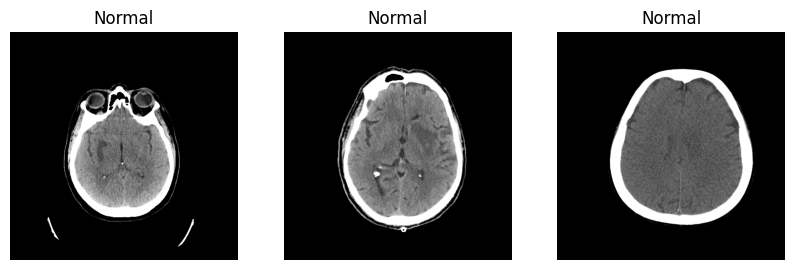

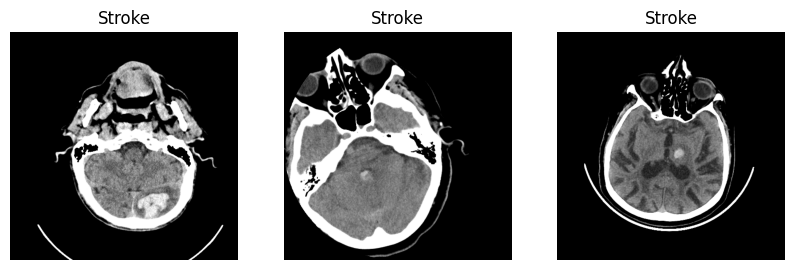

In [4]:
# Function to count files in a directory
def count_files(directory):
    return len([name for name in os.listdir(directory) if os.path.isfile(os.path.join(directory, name))])

# Count the number of images in each class
num_normal = count_files(normal_dir)
num_stroke = count_files(stroke_dir)

print(f"Number of normal CT scans: {num_normal}")
print(f"Number of stroke CT scans: {num_stroke}")

# Function to display images
def display_images(images, title):
    plt.figure(figsize=(10, 10))
    for i in range(len(images)):
        plt.subplot(1, len(images), i+1)
        img = img_to_array(load_img(images[i]))
        img = img / 255.0
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')
    plt.show()

# Display a few images from each class
normal_images_dis = [os.path.join(normal_dir, img) for img in os.listdir(normal_dir)[:3]]  # Adjust number of images to display
stroke_images_dis = [os.path.join(stroke_dir, img) for img in os.listdir(stroke_dir)[:3]]  # Adjust number of images to display

display_images(normal_images_dis, 'Normal')
display_images(stroke_images_dis, 'Stroke')


# 2. Data Preprocessing

In [5]:
# Function to print image dimensions
def print_image_dimensions(directory, label):
    dimensions = set()
    for img_name in os.listdir(directory)[:10]:  # Limiting to first 10 images for quick check
        img_path = os.path.join(directory, img_name)
        with Image.open(img_path) as img:
            dimensions.add(img.size)  # (width, height)
    print(f"{label} images dimensions: {dimensions}")

# Check dimensions for normal and stroke images
print_image_dimensions(normal_dir, 'Normal')
print_image_dimensions(stroke_dir, 'Stroke')


Normal images dimensions: {(512, 512)}
Stroke images dimensions: {(512, 584), (512, 512)}


In [6]:
# Preprocessing
def preprocess_images(image_paths, target_size=(224, 224)):
    images = []
    for image_path in image_paths:
        img = tf.keras.preprocessing.image.load_img(image_path, target_size=target_size)
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = tf.keras.applications.vgg16.preprocess_input(img_array)  # Normalization
        images.append(img_array)
    return tf.stack(images)

# Load images from folders
normal_images = preprocess_images([os.path.join(normal_dir, fname) for fname in os.listdir(normal_dir)])
stroke_images = preprocess_images([os.path.join(stroke_dir, fname) for fname in os.listdir(stroke_dir)])

# Combine images and labels
images = tf.concat([normal_images, stroke_images], axis=0)
labels = tf.concat([tf.zeros(len(normal_images)), tf.ones(len(stroke_images))], axis=0)


In [7]:
images[1].shape

TensorShape([224, 224, 3])

In [8]:
len(images)

2217

In [15]:

# Shuffle the dataset

seed = 42  # Seed for reproducibility

# Ensure the images and labels are shuffled in the same order
indices = np.arange(images.shape[0])
np.random.seed(seed)
np.random.shuffle(indices)
images = tf.gather(images, indices)
labels = tf.gather(labels, indices)

# 3. Split the dataset into training, validation, and test sets
def split_dataset(images, labels, train_size=0.7, validation_size=0.15, test_size=0.15):
    assert (train_size + validation_size + test_size) == 1

    # Calculate the indices for splitting
    total_images = images.shape[0]
    train_end = int(total_images * train_size)
    validation_end = train_end + int(total_images * validation_size)

    # Split the images and labels
    train_images = images[:train_end]
    train_labels = labels[:train_end]

    validation_images = images[train_end:validation_end]
    validation_labels = labels[train_end:validation_end]

    test_images = images[validation_end:]
    test_labels = labels[validation_end:]

    return (train_images, train_labels), (validation_images, validation_labels), (test_images, test_labels)

# Splitting the dataset
(train_images, train_labels), (validation_images, validation_labels), (test_images, test_labels) = split_dataset(images, labels)

print(f"Training data shape: {train_images.shape}, Training labels shape: {train_labels.shape}")
print(f"Validation data shape: {validation_images.shape}, Validation labels shape: {validation_labels.shape}")
print(f"Test data shape: {test_images.shape}, Test labels shape: {test_labels.shape}")


Training data shape: (1551, 224, 224, 3), Training labels shape: (1551,)
Validation data shape: (332, 224, 224, 3), Validation labels shape: (332,)
Test data shape: (334, 224, 224, 3), Test labels shape: (334,)


# 3. Feature Extraction (using a pre-trained CNN)

In [19]:


# Base_model for transfer learning is VGG16
base_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the layers of the base model

# 3. Model Building
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Dropout to prevent overfitting
    layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Early stopping and model checkpoint callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min'),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
]

# 4. Model Training


In [20]:
# Train the model
history = model.fit(
    train_images, train_labels,
    batch_size=32,
    epochs=15,  # Set a large number of epochs and let early stopping decide when to stop
    validation_data=(validation_images, validation_labels),
    callbacks=callbacks
)


Epoch 1/15
49/49 [==============================] - ETA: 0s - loss: 3.0233 - accuracy: 0.6544
Epoch 1: val_loss improved from inf to 0.56417, saving model to best_model.h5
49/49 [==============================] - 9s 156ms/step - loss: 3.0233 - accuracy: 0.6544 - val_loss: 0.5642 - val_accuracy: 0.7831
Epoch 2/15
49/49 [==============================] - ETA: 0s - loss: 0.5365 - accuracy: 0.8188
Epoch 2: val_loss improved from 0.56417 to 0.36770, saving model to best_model.h5
49/49 [==============================] - 7s 146ms/step - loss: 0.5365 - accuracy: 0.8188 - val_loss: 0.3677 - val_accuracy: 0.8494
Epoch 3/15
49/49 [==============================] - ETA: 0s - loss: 0.3121 - accuracy: 0.8711
Epoch 3: val_loss improved from 0.36770 to 0.29090, saving model to best_model.h5
49/49 [==============================] - 7s 150ms/step - loss: 0.3121 - accuracy: 0.8711 - val_loss: 0.2909 - val_accuracy: 0.8765
Epoch 4/15
49/49 [==============================] - ETA: 0s - loss: 0.1972 - accura

# 5. Model Evaluation

11/11 [==============================] - 5s 449ms/step - loss: 0.3300 - accuracy: 0.9192
Test Loss: 0.32997679710388184
Test Accuracy: 0.9191616773605347


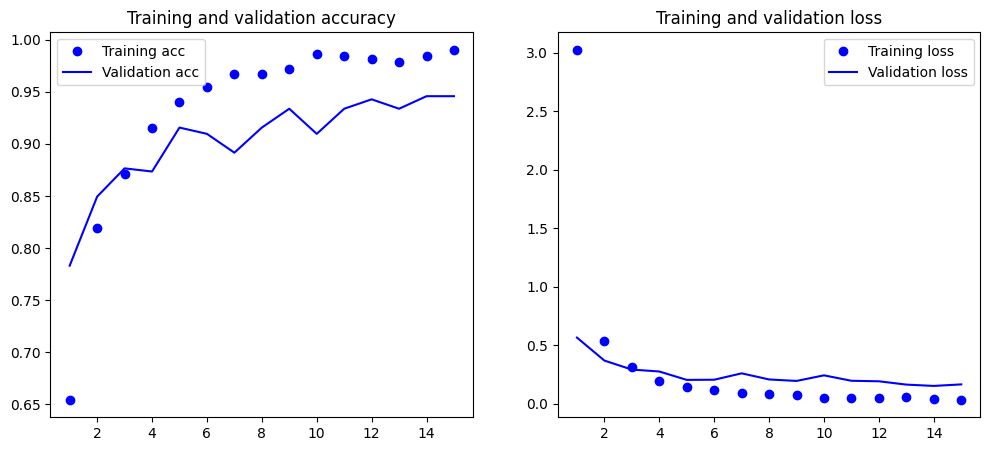

In [21]:

# Load the best model saved by the ModelCheckpoint callback
model.load_weights('best_model.h5')

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Plot training history

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_training_history(history)


# END